python3 SpikeCounter/cluster/run_preprocess_stim_jobs2.py /n/holyscratch01/cohen_lab/bjia/20230312_cmlc2_LOI None --remove_from_start 0 --remove_from_end 0 --n_pcs=40 --scale_factor=4 --skewness_threshold 0 --denoise 0 --decorrelate 0 --pb_correct_method monoexp > jobs3.txt

python3 SpikeCounter/cluster/run_sta_snapt_jobs.py /n/holyscratch01/cohen_lab/bjia/20230312_cmlc2_LOI/ --subfolder corrected --sta_after_s 3.5 --sta_before_s 1.5 --stim_channel None > jobs3.txt

python3 SpikeCounter/cluster/dcimg_folders_to_expt_data.py /n/holyscratch01/cohen_lab/bjia/20230312_cmlc2_LOI/Snaps --is_folder 0

In [1]:
import sys
from pathlib import Path
import os
import warnings
import time

sys.path.append(os.getenv("SPIKECOUNTER_PATH"))
import matplotlib as mpl
from matplotlib import patches, colors
import colorcet as cc
from cycler import cycler
import seaborn as sns
from statannotations.Annotator import Annotator

import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats, fft, interpolate, optimize
from skimage import exposure, measure, filters, transform, draw
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import mat73
import pandas as pd
import parse
import pickle

from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils

warnings.filterwarnings("once")
plt.style.use(
    os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
)
ss = StandardScaler()

In [2]:
expt_dir_name = "20230312_cmlc2_LOI"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_dir_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure5/", expt_dir_name)
os.makedirs(output_datadir, exist_ok=True)
subfolder = "corrected"
um_per_px = 0.265*4

Match nkx snaps to experiments

In [3]:
snap_metadata = pd.read_csv(rootdir/"Snaps/analysis/experiment_data.csv")

In [4]:
snap_metadata = utils.process_experiment_metadata(snap_metadata, regexp_dict={
                                                "embryo": r"(?<=\d\d)\w\d+(?=_)",
                                                "marker":r"(?<=_)[A-Za-z0-9]+(?=.tif)"})
snap_metadata["marker"] = snap_metadata["marker"].str.lower()
snap_metadata = snap_metadata[snap_metadata["embryo"] != "None"]

In [5]:
expt_info = utils.process_experiment_metadata(pd.read_csv(Path(rootdir,"analysis", subfolder, "experiment_data.csv")),
                                             regexp_dict={"embryo": r"(?<=\d\d)\w\d+(?=_)", "rate": r"(?<=\d_)\w+$"})
expt_info = expt_info[expt_info["embryo"] != "None"]
expt_info["offset"] -= expt_info["offset"].iloc[0]
expt_info = expt_info[expt_info["rate"] == "fast"]
expt_info = expt_info.reset_index(drop=True)

In [6]:
matched_myl7_snaps = utils.match_experiments_to_snaps(expt_info, snap_metadata)

In [7]:
expt_info["myl7_snap"] = matched_myl7_snaps["snap_file"]

/n/home11/bjia/SpikeCounter/spikecounter/analysis/images.py:782: FutureWarning: `selem` is a deprecated argument name for `binary_opening`. It will be removed in version 1.0. Please use `footprint` instead.
  mask = morphology.binary_opening(mask, selem=morphology.disk(opening_size))
/n/home11/bjia/SpikeCounter/spikecounter/analysis/images.py:784: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.
  mask = morphology.binary_closing(mask, selem=morphology.disk(closing_size))
/n/home11/bjia/SpikeCounter/spikecounter/analysis/images.py:919: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p, res, _, _ = np.linalg.lstsq(A, b)
/n/home11/bjia/SpikeCounter/spikecounter/ana

('10:25:55', '102555C1_fast', 227, 'C1', 'fast', '101811C1_myl7.tiff', 741.4409488204238, 585.110636996351, 97, 159, 97, 159)
('11:14:57', '111457E2_fast', 3169, 'E2', 'fast', '111150E2_myl7.tiff', 2254.789354109698, 1474.6317714881707, 158, 164, 155, 167)
('11:20:41', '112041D2_fast', 3513, 'D2', 'fast', '111701D2_myl7.tiff', 789.5394900816484, 522.0617337639808, 113, 181, 113, 179)
('11:47:43', '114743F1_fast', 5135, 'F1', 'fast', '114552F1_myl7.tiff', 1328.4966866811615, 943.7454795424051, 109, 150, 107, 147)
('11:53:13', '115313F2_fast', 5465, 'F2', 'fast', '115000F2_myl7.tiff', 1085.8958989080625, 472.2373597071554, 156, 154, 156, 154)
('12:00:38', '120038A3_fast', 5910, 'A3', 'fast', '115750A3_myl7.tiff', 1129.858471573942, 397.5168584151386, 135, 174, 134, 174)
('12:11:13', '121113A1_fast', 6545, 'A1', 'fast', '120635A1_myl7.tiff', 1274.3836762129893, 857.1184454863076, 118, 144, 117, 143)
('12:42:38', '124238B1_fast', 8430, 'B1', 'fast', '123835B1_myl7.tiff', 667.0596962395628,

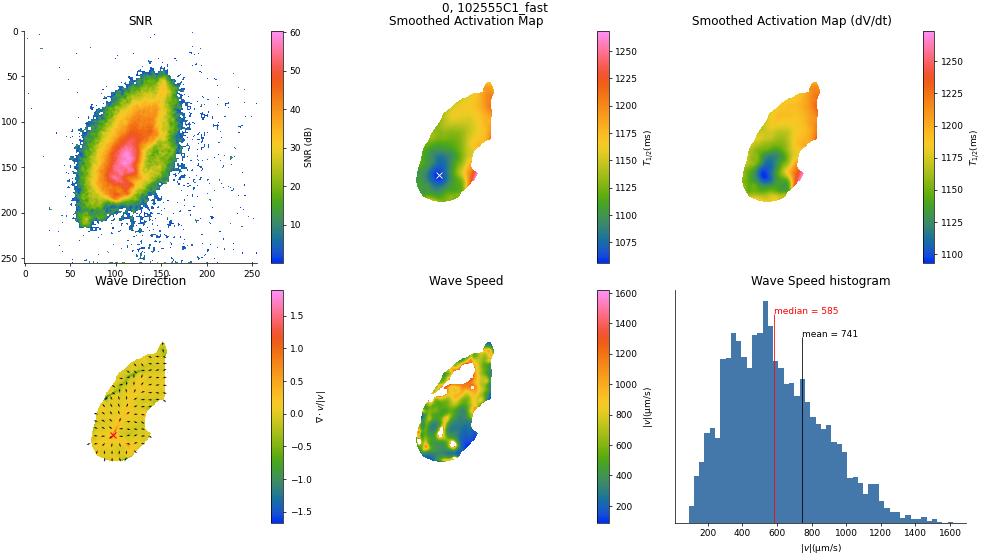

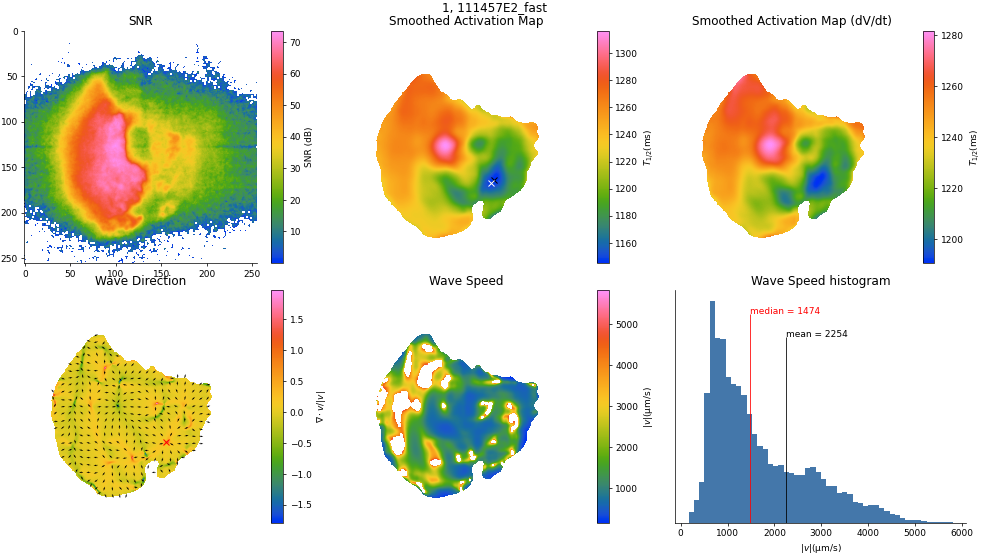

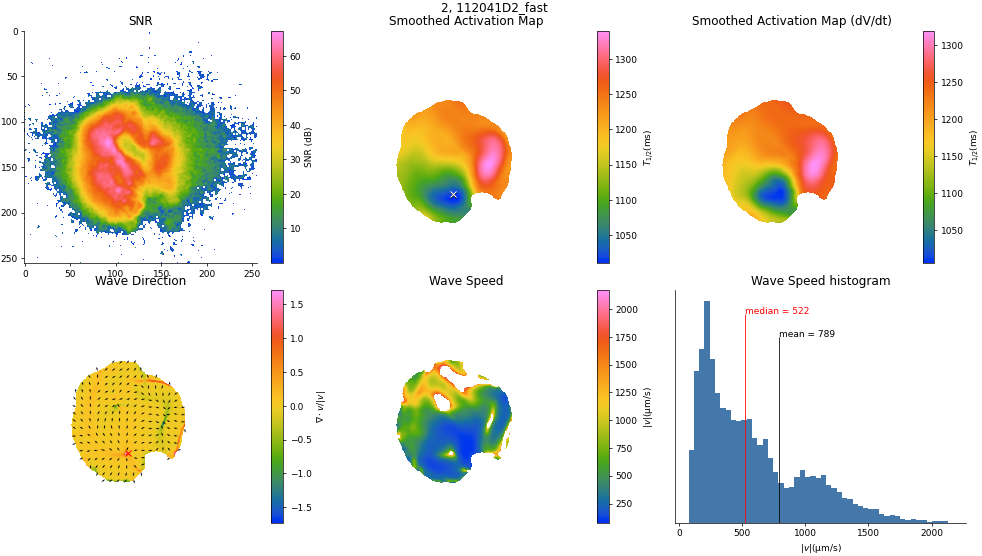

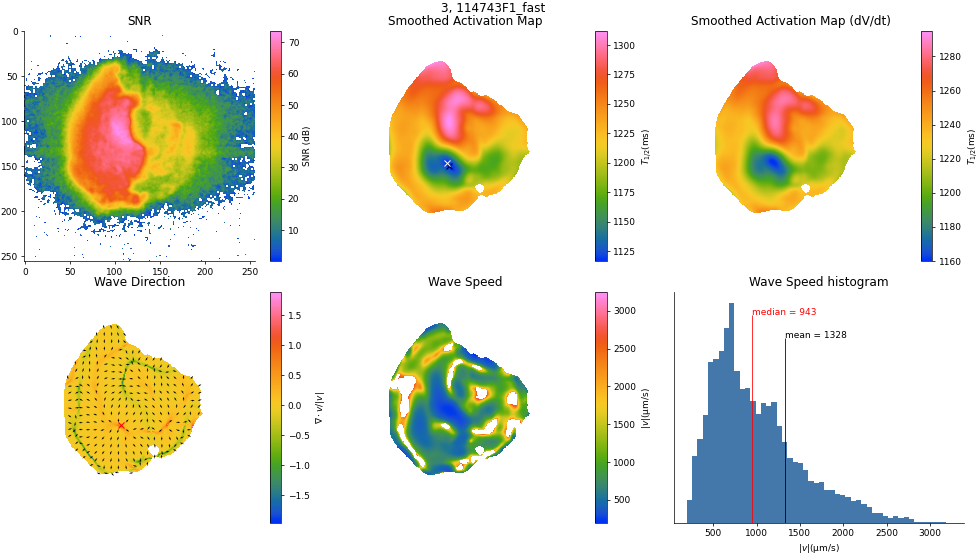

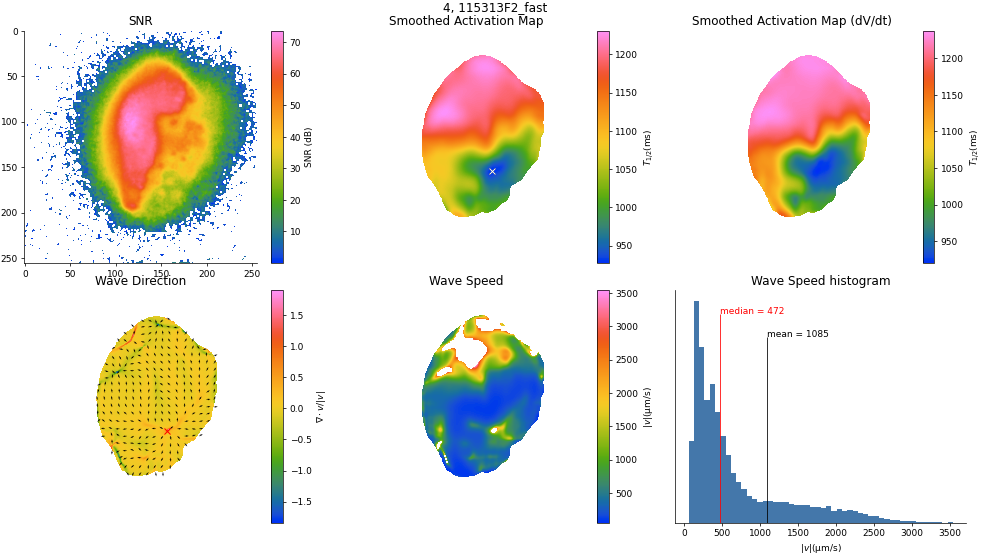

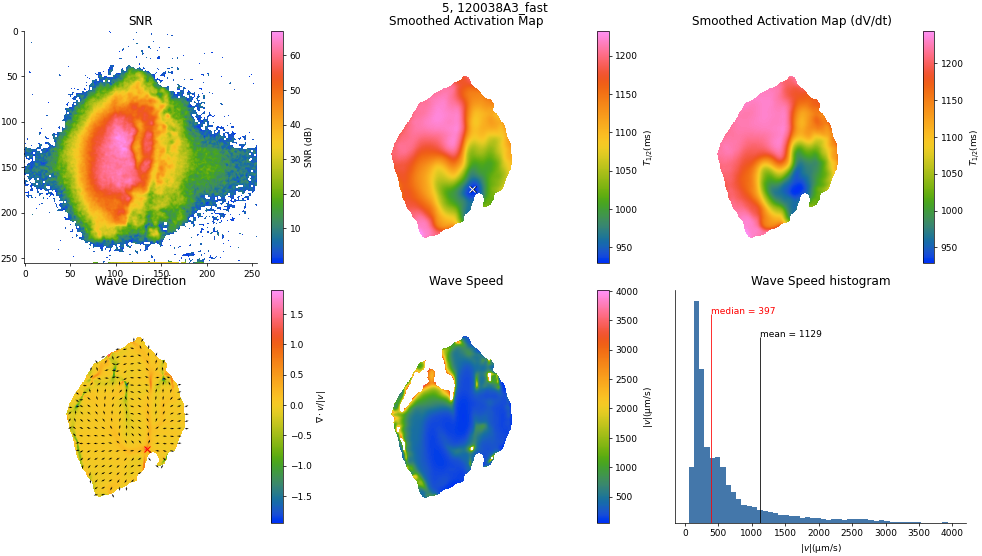

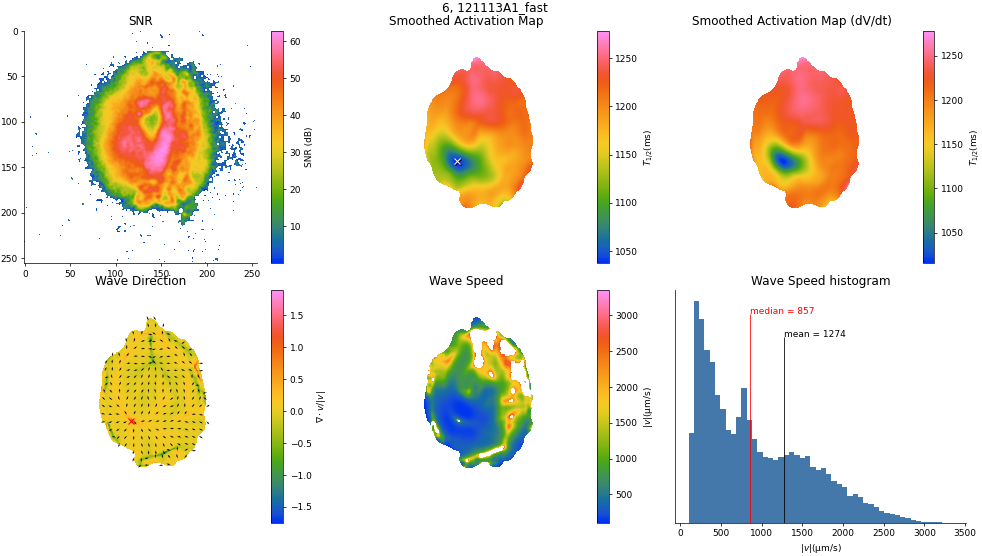

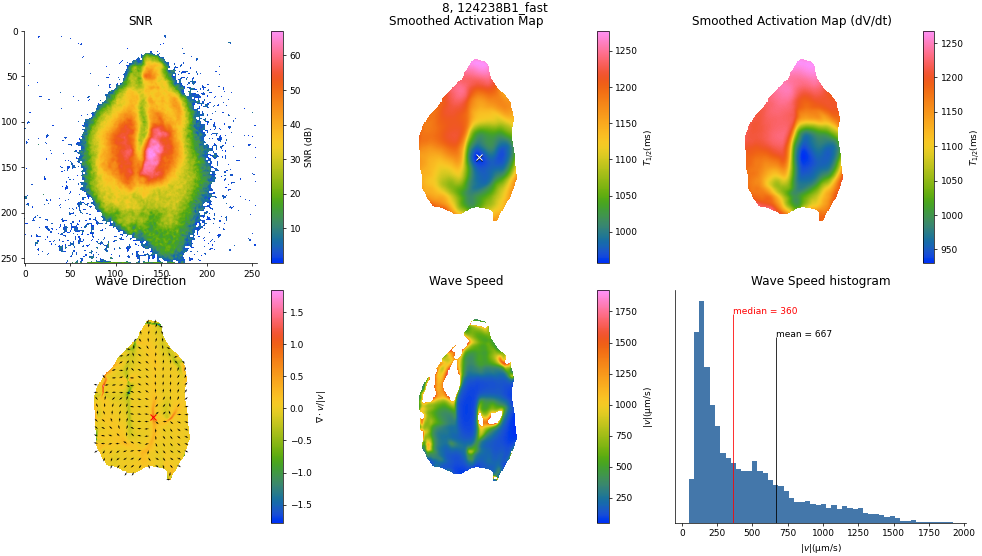

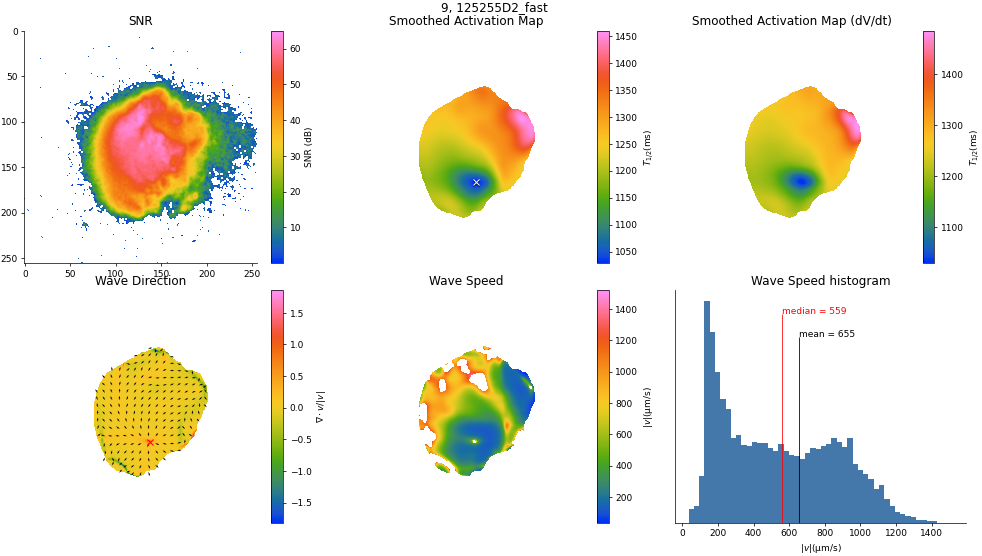

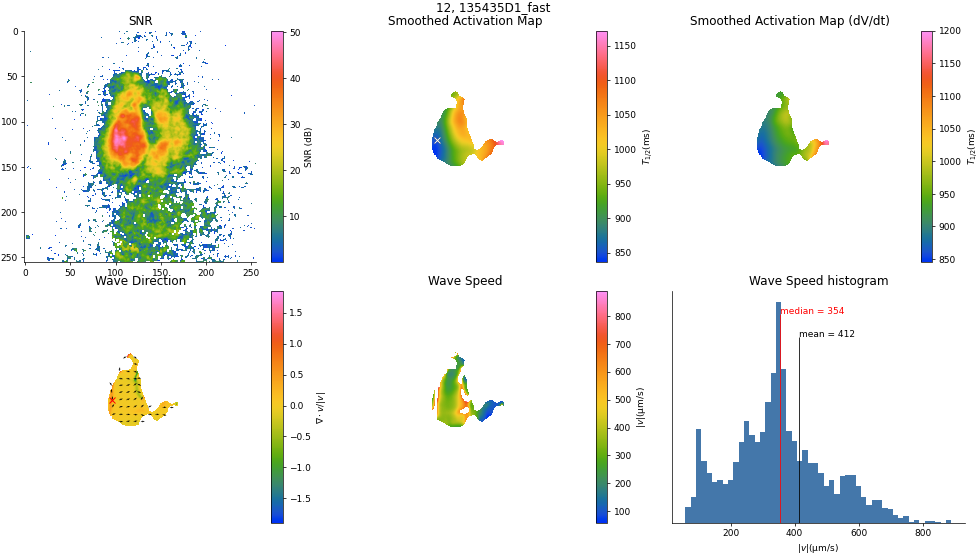

In [33]:
plt.close("all")
data = []
mint = []
maxdiv = []
erred_files = {}
smoothed_ts = {}
smoothed_ts_dv = {}
amplitudes = {}
divergences = {}
velocities = {}
for i in range(expt_info.shape[0]):
    filename = expt_info["file_name"].iloc[i]
    os.makedirs(output_datadir/"analysis"/subfolder/filename, exist_ok=True)
    snapt = f"{filename}_snapt.npz"
    if snapt in os.listdir(rootdir/"analysis"/subfolder):
        matdata = mat73.loadmat(rootdir/filename/"output_data_py.mat")["dd_compat_py"]
        ddict, t = utils.traces_to_dict(matdata)
        dt = np.mean(np.diff(t))
        
        beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]

        try:
            amplitude = (np.abs(beta[2] - 1)/beta[5])**2 #SNR
            db = 20*np.log10(amplitude)
            db[db < 0] = np.nan
            q = images.analyze_wave_dynamics(beta, dt, um_per_px, deltax=13, threshold=20)
            if q is None:
                continue
            else:
                rd, Tsmoothed, Tsmoothed_dv, divergence, v = q
            rowdata = tuple(expt_info.iloc[i]) + rd
            data.append(rowdata)
            print(rowdata)
        except Exception as e:
            print(e)
            erred_files[filename] = e
            continue
        
        smoothed_ts[filename] = Tsmoothed_dv
        amplitudes[filename] = beta[2]
        divergences[filename] = divergence
        velocities[filename] = v
        visualize.plot_wave_analysis(db, rd, Tsmoothed, Tsmoothed_dv,\
                           divergence, v, f'''{i}, {expt_info.iloc[i]["file_name"]}''')
        plt.savefig(os.path.join(rootdir/"analysis"/subfolder/filename/"waveplots.tif"))
        plt.savefig(os.path.join(output_datadir/"analysis"/subfolder/filename/"waveplots.tif"))
        
data = pd.DataFrame(data, columns = expt_info.columns.tolist() + ['mean_speed', 'median_speed', 'loi_x',\
                                                                  'loi_y', 'loi_x_dv', 'loi_y_dv'])

In [36]:
data.to_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")
with (output_datadir/"analysis"/subfolder/"wavemap_data.pickle").open(mode="wb") as f:
    pickle.dump({"erred_files": erred_files,
            "smoothed_ts": smoothed_ts,
            "smoothed_ts_dv": smoothed_ts_dv,
            "amplitudes": amplitudes,
            "divergences": divergences,
            "velocities": velocities}, f)

In [8]:
data = pd.read_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")
with (output_datadir/"analysis"/subfolder/"wavemap_data.pickle").open(mode="rb") as f:
    wavemap_data = pickle.load(f)
smoothed_ts = wavemap_data["smoothed_ts"]

In [9]:
pop_quartiles = pd.read_csv(output_datadir.parents[1]/"Figure1"/"population_frequency.csv")

In [10]:
pop_quartiles["time_post_offset_h"] = pop_quartiles["time_post_offset_h"] - pop_quartiles["time_post_offset_h"].iloc[np.argwhere(pop_quartiles["p50"].to_numpy()>0).ravel()[0]]

Overlay snap onto DF/F magnitude

In [13]:
file_name = "111457E2_fast"
row = data[data["file_name"] == file_name].iloc[0]

In [19]:
snapt = f"{file_name}_snapt.npz"
beta = np.load(os.path.join(rootdir, "analysis", subfolder, snapt))["beta"]
amplitude = beta[2]

snap = skio.imread(rootdir/"Snaps"/row["myl7_snap"])
downscaled_snap = transform.downscale_local_mean(snap, (4,4))
cropped_snap, cropped_amplitude = images.crop_min_shape(downscaled_snap, amplitude)
skio.imsave(output_datadir/f"{file_name}_myl7.tif", cropped_snap)
skio.imsave(output_datadir/f"{file_name}_amplitude.tif", cropped_amplitude)

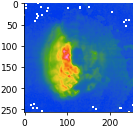

In [17]:
fig1, ax1 = plt.subplots(figsize=(2,2))
ax1.imshow(amplitude, cmap=)

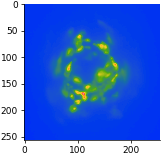

Overlay activation maps

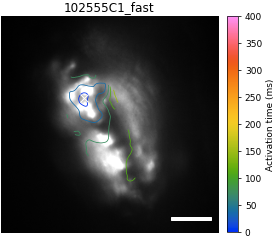

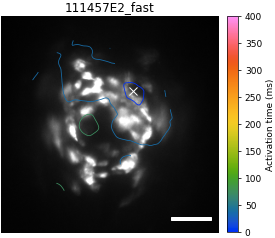

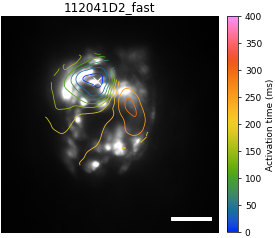

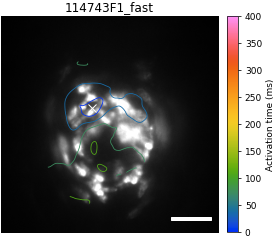

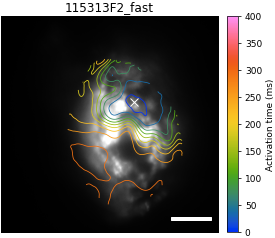

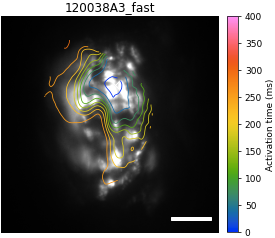

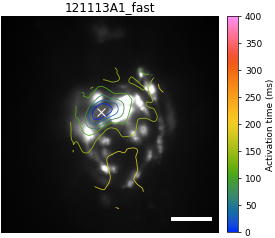

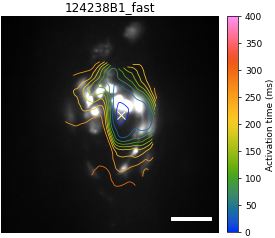

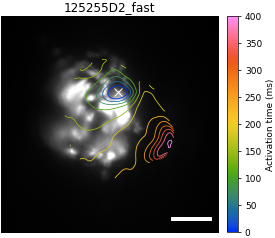

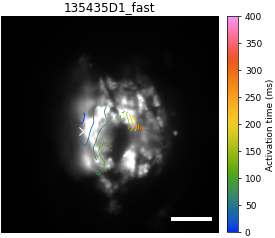

In [130]:
plt.close("all")
snap_output_dir = "myl7_LOIs"
os.makedirs(rootdir/"analysis"/subfolder/snap_output_dir, exist_ok=True)
os.makedirs(output_datadir/snap_output_dir, exist_ok=True)
p0 = 2
vmax = 400
idx = 0
radius = 2
n_random_choices = 100
np.random.seed(42)
data[["freq", "est_tpo_h"]] = None

def get_random_loc_props(cropped_snap, radius):
    mask = np.zeros_like(cropped_snap, dtype=bool)
    randy = np.random.randint(radius, cropped_snap.shape[0]-radius)
    randx = np.random.randint(radius, cropped_snap.shape[1]-radius)
    patch = draw.disk((randy, randx), radius)
    mask[patch] = True
    mean_intensity = np.mean(cropped_snap[mask])
    intensity_pctile = np.sum(cropped_snap > mean_intensity)/np.size(cropped_snap)*100
    return mean_intensity, intensity_pctile

for i, row in data.iterrows():
    # Correct sizes of snaps relative to video acquisitions assuming they are centered
    with (rootdir/"analysis"/subfolder/row["file_name"]/"temporal_statistics.pickle").open(mode="rb") as f:
        ts = pickle.load(f)
        data.loc[i, "freq"] = ts["freq"]
    snap = skio.imread(rootdir/"Snaps"/row["myl7_snap"])
    downscaled_snap = transform.downscale_local_mean(snap, (4,4))
    try:
        activation_map = smoothed_ts[row["file_name"]]
    except KeyError:
        continue
    cropped_snap, cropped_activation_map = images.crop_min_shape(downscaled_snap, activation_map)
    
    data.loc[i, "est_tpo_h"] = pop_quartiles["time_post_offset_h"].iloc[np.nanargmin((pop_quartiles["p50"]-data.loc[i, "freq"])**2)]
    
    # Measure relative myl7:GFP intensity at the LOI and compare to random
    patch = draw.disk((row["loi_y"], row["loi_x"]), radius)
    mask = np.zeros_like(cropped_snap, dtype=bool)
    mask[patch] = True
    cap = np.percentile(cropped_snap, 99)
    cropped_snap[cropped_snap > cap] = cap
    cropped_snap -= 100
    cropped_snap = exposure.rescale_intensity(cropped_snap, out_range=(0,1))
    mean_loi_intensity = np.mean(cropped_snap[mask])
    loi_intensity_pctile = (1-np.sum(cropped_snap > mean_loi_intensity)/np.size(cropped_snap))*100
    rand_sims = (get_random_loc_props(cropped_snap, radius) for i in range(n_random_choices))
    mean_rand = np.array(list((zip(rand_sims)))).squeeze().mean(axis=0)
    data["loi_myl7_intensity"].iloc[i] = mean_loi_intensity
    data["loi_myl7_intensity_pctile"].iloc[i] = loi_intensity_pctile
    data["randloc_myl7_intensity"].iloc[i] = mean_rand[0]
    data["randloc_myl7_intensity_pctile"].iloc[i] = mean_rand[1]
    data["img_mean_intensity"].iloc[i] = np.mean(cropped_snap)
    # Measure mean intensity of active area:
    finite_mask = np.isfinite(cropped_activation_map)
    data["active_area_intensity_mean"].iloc[i] = np.mean(cropped_snap[finite_mask])
    rand_means = np.zeros(n_random_choices)
    for j in range(n_random_choices):
        rand_mask = np.zeros(np.size(finite_mask), dtype=bool)
        rand_mask[np.random.choice(len(rand_mask), size=np.sum(finite_mask), replace=False)] = True
        rand_means[j] = np.mean(cropped_snap[rand_mask.reshape(cropped_snap.shape)])
    data["rand_area_intensity_mean"].iloc[i] = rand_means.mean()
    data.loc[i, "active_area_intensity_pctile"]= np.sum(cropped_snap 
                            < data["active_area_intensity_mean"].iloc[i])/np.size(cropped_snap)*100
    data.loc[i, "rand_area_intensity_pctile"]= np.sum(cropped_snap 
                            < data["rand_area_intensity_mean"].iloc[i])/np.size(cropped_snap)*100
    
    # Plot activation maps on top of myl7:GFP images
    fv = cropped_activation_map[finite_mask]
    Tsmoothed_apod = cropped_activation_map - np.percentile(fv, p0)        
    fig1, ax1 = plt.subplots(figsize=(4,4))
    ax1.imshow(downscaled_snap, cmap = "gray")
    cs = ax1.contour(Tsmoothed_apod, levels=np.linspace(0, vmax, 12), cmap="cet_CET_R1")
    
    ax1.plot(data["loi_x_dv"].iloc[idx], data["loi_y_dv"].iloc[idx], "wx", markersize=8)
    ax1.set_ylim(0,downscaled_snap.shape[0])
    ax1.set_title(row['file_name'])
    ax1.axis("off")
    visualize.plot_img_scalebar(fig1, ax1, 200, 15, 50, 4, pix_per_um = 1/um_per_px, fontsize=9,
                              color="white", unit="\mu m", yax_direction="up", text_pos="below", scale=0.7,
                             show_label=False)
    norm = colors.Normalize(vmin=0, vmax=vmax)
    cax = fig1.add_axes([0.92, 0.13, 0.04, 0.75])
    cb = mpl.colorbar.ColorbarBase(cax, cmap="cet_CET_R1", norm=norm, label="Activation time (ms)")
#     break
    fig1.savefig(rootdir/"analysis"/subfolder/snap_output_dir/f"{row['file_name']}.tif", dpi=300, bbox_inches="tight")
    fig1.savefig(output_datadir/snap_output_dir/f"{row['file_name']}.tif", dpi=300, bbox_inches="tight")
    fig1.savefig(output_datadir/snap_output_dir/f"{row['file_name']}.svg", dpi=300, bbox_inches="tight")

    idx +=1

In [131]:
data.reset_index().to_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")

In [6]:
data = pd.read_csv(output_datadir/"analysis"/subfolder/"waveprop_data.csv")

In [7]:
def remap_sample_intensity(df, sample_index, col, new_name, label_maps = {}):
    new_df = df[[sample_index, col]].rename(columns={col: new_name})
    for key, val in label_maps.items():
        new_df[key] = val
    return new_df

In [8]:
d1 = remap_sample_intensity(data, "file_name", "loi_myl7_intensity", "intensity", label_maps={"area": "LOI", "cond": "Segmented"})
d2 = remap_sample_intensity(data, "file_name", "randloc_myl7_intensity", "intensity", label_maps={"area": "LOI", "cond": "Random"})
d3 = remap_sample_intensity(data, "file_name", "active_area_intensity_mean", "intensity", label_maps={"area": "Active", "cond": "Segmented"})
d4 = remap_sample_intensity(data, "file_name", "rand_area_intensity_mean", "intensity", label_maps={"area": "Active", "cond": "Random"})
d5 = remap_sample_intensity(data, "file_name", "img_mean_intensity", "intensity", label_maps={"area": "Mean", "cond": "Segmented"})

comparison_df = pd.concat([d2,d1,d4,d3, d5], axis=0)
comparison_df = comparison_df[comparison_df["cond"] != "Random"]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mean vs. Active: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00
Mean vs. LOI: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.953e-03 Stat=0.000e+00


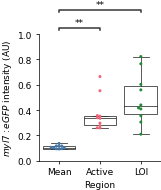

In [11]:
x = "area"
y="intensity"
fig1, ax1 = plt.subplots(figsize=(2.5,3))
order = ["Mean", "Active", "LOI"]
sns.boxplot(data=comparison_df, x=x, y=y, fliersize=0, order=order, boxprops={
    "facecolor": (0,0,0,0)
})
sns.swarmplot(data=comparison_df, x=x, y=y, s=3, order=order)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Region")
ax1.set_ylabel(r"$\it{myl7:eGFP}$ intensity (AU)")
pairs = [("Mean", "Active"), ("Mean", "LOI")]
annot = Annotator(ax1, pairs, data=comparison_df, x=x,y=y, order=order)
annot.configure(test="Wilcoxon", verbose=2, loc="outside", comparisons_correction="BH")
annot.apply_and_annotate()
plt.tight_layout()
fig1.savefig(output_datadir/"myl7_intensity_comparison2.svg", dpi=300, bbox_inches="tight")


/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'ROI')

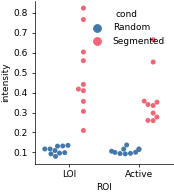

In [77]:
x = "area"
y="intensity"
fig1, ax1 = plt.subplots(figsize=(2.5,3))
order = ["Random", "Segmented"]
sns.swarmplot(data=comparison_df, x=x, y=y, hue="cond", hue_order=order, dodge=True)
ax1.set_xlabel("ROI")

In [92]:
for idx in grouped_data.index.unique():
    print(stats.shapiro(grouped_data.loc[idx]["intensity"]))

ShapiroResult(statistic=0.9399850368499756, pvalue=0.5528468489646912)
ShapiroResult(statistic=0.9483681321144104, pvalue=0.649233341217041)
ShapiroResult(statistic=0.8967131972312927, pvalue=0.20154836773872375)
ShapiroResult(statistic=0.7727611064910889, pvalue=0.006757466588169336)


/tmp/ipykernel_95359/396355734.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(stats.shapiro(grouped_data.loc[idx]["intensity"]))


In [ ]:
x = "area"
y="intensity"
fig1, ax1 = plt.subplots(figsize=(2.5,3))
order = ["Random", "Segmented"]
sns.boxplot(data=comparison_df, x=x, y=y, hue="cond", fliersize=0,hue_order=order)

/tmp/ipykernel_95359/1118844616.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.scatter(-0.2*np.ones(grouped_data.loc[(area,cond_index[0])].shape[0]) + i,
/tmp/ipykernel_95359/1118844616.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax1.scatter(-0.2*np.ones(grouped_data.loc[(area,cond_index[0])].shape[0]) + i,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Active_Random vs. Active_Segmented: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
LOI_Random vs. LOI_Segmented: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00


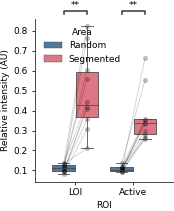

In [100]:
x = "area"
y="intensity"
fig1, ax1 = plt.subplots(figsize=(2.5,3))
order = ["Random", "Segmented"]
sns.boxplot(data=comparison_df, x=x, y=y, hue="cond", fliersize=0,hue_order=order)
ax1.set_xlabel("ROI")
ax1.set_ylabel("Relative intensity (AU)")
grouped_data = comparison_df.set_index(["area", "cond"])

area_index = grouped_data.index.unique("area")
cond_index = grouped_data.index.unique("cond")
for i, area in enumerate(area_index):
    ax1.scatter(-0.2*np.ones(grouped_data.loc[(area,cond_index[0])].shape[0]) + i, 
                grouped_data.loc[(area,cond_index[0])][y],
                alpha=0.2, color="k", s=16)
    ax1.scatter(0.2*np.ones(grouped_data.loc[(area,cond_index[1])].shape[0]) + i, 
                grouped_data.loc[(area,cond_index[1])][y],
                alpha=0.2, color="k", s=16)
    ax1.plot(np.array([-0.2*np.ones(grouped_data.loc[(area,cond_index[0])].shape[0]) + 0, 
                       0.2*np.ones(grouped_data.loc[(area,cond_index[1])].shape[0])]) + i,
        np.array([grouped_data.loc[(area,cond_index[0])][y].values,  grouped_data.loc[(area,cond_index[1])][y].values]),
        color="k", alpha=0.2)

ax1.legend(
    title="Area", markerscale=0.5
)
pairs = [[("LOI", "Random"), ("LOI", "Segmented")], [("Active", "Random"), ("Active", "Segmented")]]
annot = Annotator(ax1, pairs, data=comparison_df, x=x,y=y, hue="cond", hue_order=order)
annot.configure(test="Wilcoxon", verbose=2, loc="outside")
annot.apply_and_annotate()
fig1.savefig(output_datadir/"myl7_intensity_comparison.svg", dpi=300, bbox_inches="tight")
comparison_df.to_csv(output_datadir/"myl7_intensity_comparison.csv", index=False)

# ax1.legend().set_visible(False)

In [120]:
comparison_df

,file_name,intensity,area,cond
0,102555C1_fast,0.766031,LOI,Segmented
1,111457E2_fast,0.210103,LOI,Segmented
2,112041D2_fast,0.417576,LOI,Segmented
3,114743F1_fast,0.305902,LOI,Segmented
4,115313F2_fast,0.440892,LOI,Segmented
5,120038A3_fast,0.823313,LOI,Segmented
6,121113A1_fast,0.355736,LOI,Segmented
7,124238B1_fast,0.559842,LOI,Segmented
8,125255D2_fast,0.409619,LOI,Segmented
9,135435D1_fast,0.603265,LOI,Segmented


Compare myl7 intensity with SNR

In [20]:
subfolder="corrected"

In [21]:
exclude_list = ["130350C3_fast", "122130E1_fast", "140023E3_fast"]

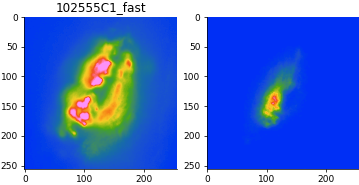

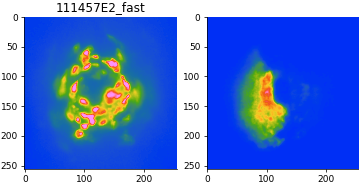

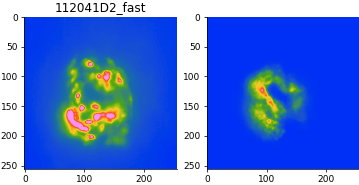

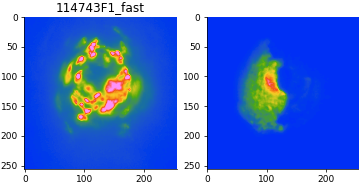

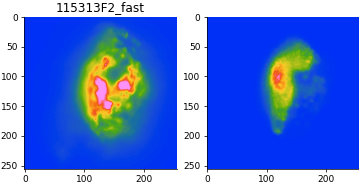

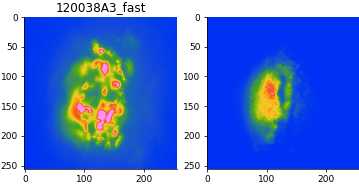

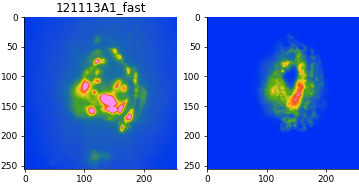

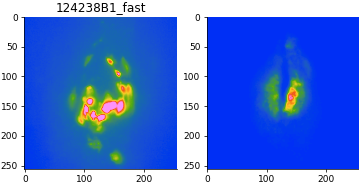

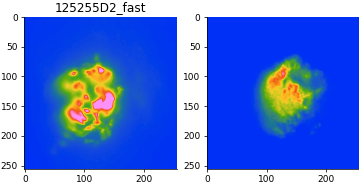

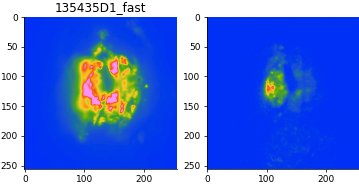

In [33]:
plt.close("all")
myl7_vs_frgeco = []
for i, row in expt_info.iterrows():
    if row['file_name'] in exclude_list:
        continue
    snap_path = rootdir/"Snaps"/row["myl7_snap"]
    try:
        beta = np.load(rootdir/"analysis"/subfolder/f"{row['file_name']}_snapt.npz")["beta"]
    except FileNotFoundError:
        continue
    snr = np.nan_to_num((np.abs(beta[2] - 1)/beta[5])**2, nan=0)
    snap = images.match_snap_to_data(skio.imread(snap_path), snr) - 100
    dff = np.nan_to_num(beta[2] - 1, nan=0)
    clamp = np.percentile(snap, 99)
    snap[snap > clamp] = clamp
    snap = exposure.rescale_intensity(snap, out_range=(0,1))
    fig1, axs = plt.subplots(1,2, figsize=(6,3))
    axs[0].imshow(snap)
    axs[1].imshow(snr)
    axs[0].set_title(row["file_name"])
    img_df = pd.DataFrame({
        "expt_name": [expt_dir_name]*64,
        "file_name": [str(row["file_name"])]*64,
        "embryo": [row["embryo"]]*64,
        "intensity_norm": transform.resize(snap, (8,8)).ravel(),
        "snr": transform.resize(snr, (8,8)).ravel(),
        "dff": transform.resize(dff, (8,8)).ravel(),
        "cond": ["myl7"]*64
    })
    myl7_vs_frgeco.append(img_df)

In [36]:
myl7_frgeco_df = pd.concat(myl7_vs_frgeco, axis=0)

In [37]:
myl7_frgeco_df["snr_db"] = 10*np.log10(myl7_frgeco_df["snr"])

Text(0, 0.5, 'FRGECO1c $\\mathrm{SNR^2}$ (dB)')

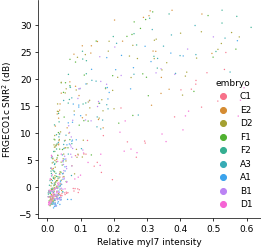

In [38]:
fig1, ax1 = plt.subplots(figsize=(4,4))
sns.scatterplot(data=myl7_frgeco_df, x="intensity_norm", y="snr_db", s=2, hue="embryo")
ax1.set_xlabel("Relative myl7 intensity")
ax1.set_ylabel(r"FRGECO1c $\mathrm{SNR^2}$ (dB)")


Text(0, 0.5, 'FRGECO1c dFF')

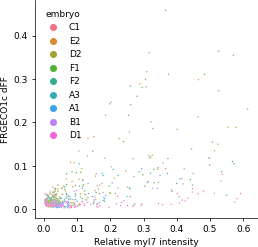

In [32]:
fig1, ax1 = plt.subplots(figsize=(4,4))
sns.scatterplot(data=myl7_frgeco_df, x="intensity_norm", y="dff", s=2, hue="embryo")
ax1.set_xlabel("Relative myl7 intensity")
ax1.set_ylabel(r"FRGECO1c dFF")

In [39]:
myl7_frgeco_df.reset_index().to_csv(output_datadir/"myl7_intensity_vs_snr.csv", index=False)

In [21]:
myl7_frgeco_df = pd.read_csv(output_datadir/"myl7_intensity_vs_snr.csv")

In [22]:
nkx_intensity = pd.read_csv(output_datadir.parent/"nkx_intensity_vs_snr.csv")

In [23]:
myl7_frgeco_df = myl7_frgeco_df.rename(columns={"myl7_intensity_norm": "intensity_norm"})
myl7_frgeco_df["cond"] = "myl7"

In [24]:
all_intensity_snr = pd.concat([nkx_intensity, myl7_frgeco_df], axis=0)

In [25]:
all_intensity_snr["log_intensity_norm"] = np.log10(all_intensity_snr["intensity_norm"] + 1e-5)

In [26]:
dat_by_cond = all_intensity_snr.set_index("cond")

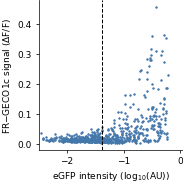

In [27]:
fig1, ax1 = plt.subplots(figsize=(2.8,2.8))
# sns.scatterplot(data=all_intensity_snr, x="log_intensity_norm", y="snr_db", s=2, hue="cond")
q = ax1.scatter(dat_by_cond.loc["myl7", "log_intensity_norm"],dat_by_cond.loc["myl7", "dff"], s= 2)
q.set_rasterized(True)
ax1.set_xlabel(r"$\mathrm{eGFP\ intensity\ (\log_{10}(AU))}$")
ax1.set_ylabel(r"$\mathrm{FR{-}GECO1c\ signal\ (\Delta F /F)}$")
ax1.axvline(np.percentile(dat_by_cond.loc["myl7", "log_intensity_norm"], 50),
            color="k", linestyle="--", linewidth=1)
# ax1.axhline(10,color="k", linestyle="--", linewidth=1)
# ax1.set_ylim((-5, 49.43858677710165))
ax1.set_xlim((-2.5, 0.04658652016431183))
plt.tight_layout()
plt.savefig(output_datadir.parent/"myl7_frgeco_tiled_intensity_dff.svg", dpi=300)

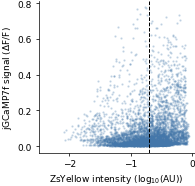

In [28]:
fig1, ax1 = plt.subplots(figsize=(2.8,2.8))
# sns.scatterplot(data=all_intensity_snr, x="log_intensity_norm", y="snr_db", s=2, hue="cond")
q = ax1.scatter(dat_by_cond.loc["nkx", "log_intensity_norm"],dat_by_cond.loc["nkx", "dff"], s= 2, alpha=0.2, color="C1")
q.set_rasterized(True)
ax1.set_xlabel(r"$\mathrm{ZsYellow\ intensity\ (\log_{10}(AU))}$")
ax1.set_ylabel(r"$\mathrm{jGCaMP7f\ signal\ (\Delta F /F)}$")
ax1.axvline(np.percentile(dat_by_cond.loc["nkx", "log_intensity_norm"], 50),
            color="k", linestyle="--", linewidth=1)
# ax1.axhline(10,color="k", linestyle="--", linewidth=1)
# ax1.set_ylim((-5, 49.43858677710165))
ax1.set_xlim((-2.5, 0.04658652016431183))
plt.savefig(output_datadir.parent/"nkx2.5_gcamp_tiled_intensity_dff.svg", dpi=300)

In [115]:
ax1.get_xlim()

(-2.1822974194705065, 0.04658652016431183)

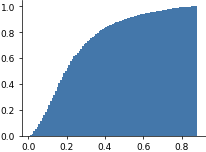

In [83]:
q = plt.hist(all_intensity_snr.set_index("cond").loc["nkx"]["intensity_norm"], cumulative=True, density=True, bins=100)

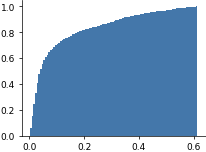

In [84]:
q = plt.hist(all_intensity_snr.set_index("cond").loc["myl7"]["intensity_norm"], cumulative=True, density=True, bins=100)